# Sparse Target Dataset Hyperparameters Tunning
The objective of this notebook is to tune the hyperparameters of the model to obtain the best performance on the sparse dataset. 

**Summary of the Article**
- Description of the dataset.
- Hyperparameters tunning:
    - Gradient Boosting Regressor.
    - SVRegressor.
    - Multi-Layer Perceptron.
    - Long-Short Term Memory.
- Training Models.
- Next Steps.

## Description of the Sparse Dataset 
The objective of this master thesis is to forecast the occurance and amplitude of constraints in the electrical grid. Using historical values of active and reactive power it is possible to compute the voltage and current values in the network, thus obtaining the occurance and amplitude of constraints. Since not every timestep containts a constraint, not every time step is woth to be predicted, so it is usefull transform the target features into a sequece of values that better represent the constraints. One way to obtain this target dataset is to set all time steps that do not characterise a constraint to 0, a positive value (with the amplitude of the constraint) otherwise. The following formula states the transformation:
$$
    \begin{align}
        \text{Target} &= \begin{cases}
            0 & \text{if} \; \text{constraint} \; \text{is not violated} \\
            \text{amplitude of constraint} & \text{if} \; \text{constraint} \; \text{is violated} \\
        \end{cases}
    \end{align}
$$

The resulting dataset is a sparse dataset, since constraints are not as common as regular values. Bellow the dataset for maximum voltage constraints is shown.

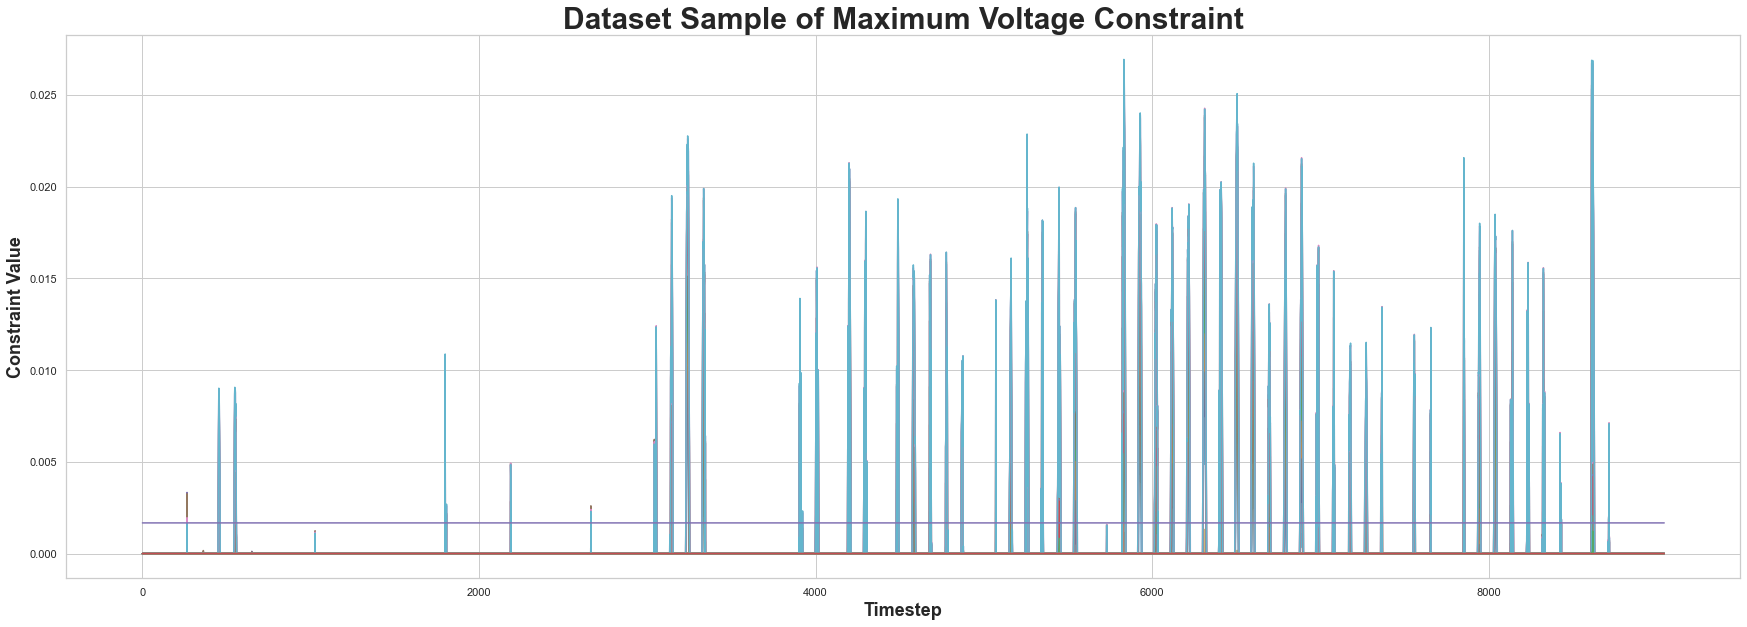

In [1]:
import sys; sys.path.append('..')
from thesis_package import utils

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

y_max_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_constr.csv').drop(columns='timestamps')
exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
X_max_u_train, X_max_u_test, y_max_u_train, y_max_u_test = utils.split_and_suffle(exogenous_data, y_max_u)
data = {'X_train': X_max_u_train, 'X_test': X_max_u_test, 'y_train': y_max_u_train, 'y_test': y_max_u_test}
threshold_value = y_max_u_train.loc[:, y_max_u_train.max(axis=0) != 0].max(axis=0).mean() * 0.1 
threshold_signal = pd.Series(np.ones([len(y_max_u_test)]) * threshold_value)
# Plot prediction_gb_max_u
sns.set(style='whitegrid')
fig, axs = plt.subplots(1, 1, figsize=(30, 10))
axs.plot(y_max_u_test.reset_index(drop=True))
axs.plot(threshold_signal)
axs.set_title('Dataset Sample of Maximum Voltage Constraint', fontsize=30, fontweight='bold')
axs.set_xlabel('Timestep', fontsize=18, fontweight='bold')
axs.set_ylabel('Constraint Value', fontsize=18, fontweight='bold')
plt.show()

The sparse boolean dataset is derived from the one above. It represents the time steps with constraints as of the class 1 and the rest as class 0. This datset is used to train the classification models.

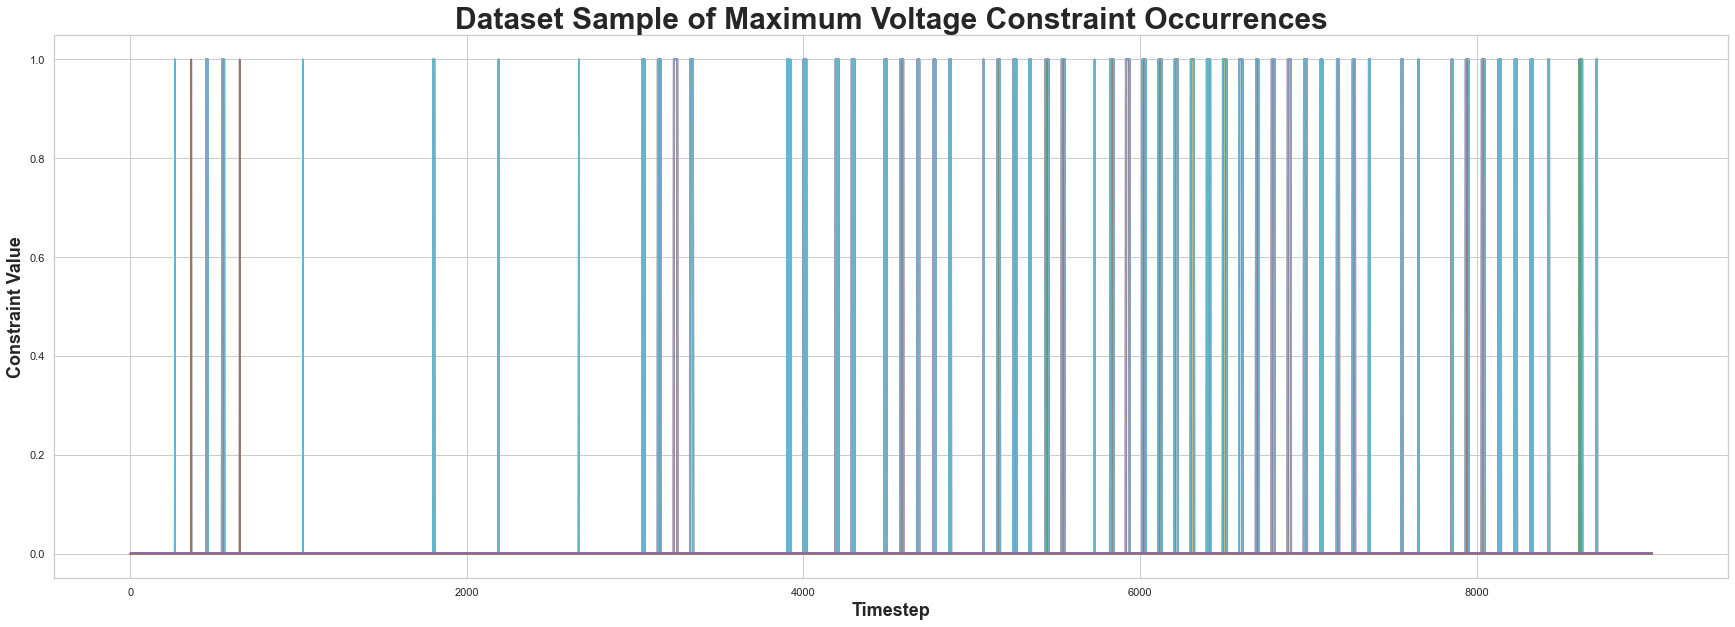

In [2]:
y_max_u_bool = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_bool_constr.csv').drop(columns='timestamps')
exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
X_max_u_bool_train, X_max_u_bool_test, y_max_u_bool_train, y_max_u_bool_test = utils.split_and_suffle(exogenous_data, y_max_u_bool)
data = {'X_train': X_max_u_bool_train,
        'X_test': X_max_u_bool_test,
        'y_train': utils.convert_df_to_bool(y_max_u_bool_train),
        'y_test': utils.convert_df_to_bool(y_max_u_bool_test)}
# Plot prediction_gb_max_u
sns.set(style='whitegrid')
fig, axs = plt.subplots(1, 1, figsize=(30, 10))
axs.plot(y_max_u_bool_test.reset_index(drop=True))
axs.plot(threshold_signal)
axs.set_title('Dataset Sample of Maximum Voltage Constraint Occurrences', fontsize=30, fontweight='bold')
axs.set_xlabel('Timestep', fontsize=18, fontweight='bold')
axs.set_ylabel('Constraint Value', fontsize=18, fontweight='bold')
plt.show()

However, not all busses have constraints, so it is only possible train classification models for those busses that have positive values in the target dataset.

In [3]:
utils.cols_with_positive_values(y_max_u_bool)

['bus_7',
 'bus_8',
 'bus_9',
 'bus_10',
 'bus_11',
 'bus_12',
 'bus_13',
 'bus_14',
 'bus_15',
 'bus_16',
 'bus_24',
 'bus_18',
 'bus_32']

## Import Libraries

In [4]:
import optuna 
import os

import numpy as np
import pandas as pd 
import sklearn.metrics
from sklearn.model_selection import train_test_split

import sys
sys.path.append('..')
from thesis_package import aimodels as my_ai, utils, metrics

c:\Users\jamil\Documents\IST\Thesis\new_thesis\code\AI-to-forecast-constraints-in-the-energy-systems\env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Hyperparameters Tunning of Models
The objective of this section is to tune the hyperparameters of the models to obtain the best performance on the sparse dataset. In order to perfom the hyperparameters tunning, we are going to use the optuna library presented in the `optuna_introduction.ipynb` notebook. The models are the ones implemented in the `aimodel.py` file in the `thesis_package`.

In [5]:
# General parameters
num_trials = 100

### Extreme Gradient Boosting Regressor

In [6]:
def objective(trial):
    # import data
    y_max_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_constr.csv').drop(columns=['timestamps'])
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y = utils.split_and_suffle(exogenous_data, y_max_u)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        # use exact for small dataset.
        "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    model = my_ai.Context(my_ai.XGBoostRegressorStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    prediction = pd.DataFrame(prediction , columns=valid_y.columns)
    # evaluate the regression performance with my metrics
    threshold = train_y.loc[:, train_y.max(axis=0) != 0].max(axis=0).mean() * 0.1 
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, valid_y, threshold=threshold)
    return metric.true_positives_rmse

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results/params_xgboost_regression_sparse_max_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-09-03 09:28:37,680] A new study created in memory with name: no-name-211aadd4-6b93-41da-815e-d8a2679db5bc


KeyboardInterrupt: 

In [ ]:
def objective(trial):
    # import data
    y_min_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_constr.csv').drop(columns=['timestamps'])
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y = utils.split_and_suffle(exogenous_data, y_min_u)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        # use exact for small dataset.
        "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    model = my_ai.Context(my_ai.XGBoostRegressorStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    prediction = pd.DataFrame(prediction , columns=valid_y.columns)
    # evaluate the regression performance with my metrics
    threshold = train_y.loc[:, train_y.max(axis=0) != 0].max(axis=0).mean() * 0.1 
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, valid_y, threshold=threshold)
    return metric.true_positives_rmse
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results/params_xgboost_regression_sparse_min_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-08-21 23:11:45,567] A new study created in memory with name: no-name-a1e6e51f-b45f-47d1-8368-68e5a66275d9
[I 2022-08-21 23:12:23,940] Trial 0 finished with value: 0.008417136569301377 and parameters: {'booster': 'gblinear', 'lambda': 0.0002263866914847617, 'alpha': 0.006469525860429082, 'subsample': 0.48998300345676027, 'colsample_bytree': 0.27057435456398793}. Best is trial 0 with value: 0.008417136569301377.
[I 2022-08-21 23:13:02,354] Trial 1 finished with value: 0.0 and parameters: {'booster': 'gblinear', 'lambda': 0.05222241453451214, 'alpha': 0.4796424371172093, 'subsample': 0.8991281740894908, 'colsample_bytree': 0.9143759295062182}. Best is trial 1 with value: 0.0.
[I 2022-08-21 23:13:40,462] Trial 2 finished with value: 0.011016408576467818 and parameters: {'booster': 'gblinear', 'lambda': 2.629693381614867e-08, 'alpha': 0.0003078770743906238, 'subsample': 0.8671843452110428, 'colsample_bytree': 0.5056620296473313}. Best is trial 1 with value: 0.0.
[I 2022-08-21 23:17:

Number of finished trials:  100
Best trial:
  Value: 0.0
  Params: 
    booster: gblinear
    lambda: 0.05222241453451214
    alpha: 0.4796424371172093
    subsample: 0.8991281740894908
    colsample_bytree: 0.9143759295062182


### Gradient Boosting Regressor

In [ ]:
# Same implementation as above, but for Gradient Boosting Regression.
def objective(trial):
    # import data
    y_max_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_constr.csv').drop(columns=['timestamps'])
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y = utils.split_and_suffle(exogenous_data, y_max_u)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 1.0, log=True) ,
        'loss': trial.suggest_categorical('loss', ['squared_error', 'absolute_error'])
    }
    model = my_ai.Context(my_ai.GradientBoostRegressorStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    prediction = pd.DataFrame(prediction , columns=valid_y.columns)
    # evaluate the regression performance with my metrics
    threshold = train_y.loc[:, train_y.max(axis=0) != 0].max(axis=0).mean() * 0.1 
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, valid_y, threshold=threshold)
    return metric.true_positives_rmse
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results/params_gradient_boost_regression_sparse_max_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-08-22 00:52:27,105] A new study created in memory with name: no-name-28493c43-a5b6-4222-bdb4-75785c74336e
[I 2022-08-22 00:54:31,784] Trial 0 finished with value: 0.011224964821489443 and parameters: {'n_estimators': 64, 'learning_rate': 0.35794359268401005, 'loss': 'absolute_error'}. Best is trial 0 with value: 0.011224964821489443.
[I 2022-08-22 01:00:48,932] Trial 1 finished with value: 0.006815382019757212 and parameters: {'n_estimators': 225, 'learning_rate': 0.13303414490819782, 'loss': 'squared_error'}. Best is trial 1 with value: 0.006815382019757212.
[I 2022-08-22 01:23:05,633] Trial 2 finished with value: 0.006613575997857353 and parameters: {'n_estimators': 898, 'learning_rate': 0.188876040207717, 'loss': 'squared_error'}. Best is trial 2 with value: 0.006613575997857353.
[I 2022-08-22 01:23:47,162] Trial 3 finished with value: 0.009200714185762 and parameters: {'n_estimators': 12, 'learning_rate': 0.10516690095079279, 'loss': 'squared_error'}. Best is trial 2 with v

Number of finished trials:  100
Best trial:
  Value: 0.0064745090355284845
  Params: 
    n_estimators: 544
    learning_rate: 0.36423151911958196
    loss: squared_error


In [ ]:
# Same implementation as above, but for Gradient Boosting Regression.
def objective(trial):
    # import data
    y_min_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_constr.csv').drop(columns=['timestamps'])
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y = utils.split_and_suffle(exogenous_data, y_min_u)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 1.0, log=True) ,
        'loss': trial.suggest_categorical('loss', ['squared_error', 'absolute_error'])
    }
    model = my_ai.Context(my_ai.GradientBoostRegressorStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    prediction = pd.DataFrame(prediction , columns=valid_y.columns)
    # evaluate the regression performance with my metrics
    threshold = train_y.loc[:, train_y.max(axis=0) != 0].max(axis=0).mean() * 0.1 
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, valid_y, threshold=threshold)
    return metric.true_positives_rmse
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results/params_gradient_boost_regression_sparse_min_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-08-22 23:38:25,373] A new study created in memory with name: no-name-53b64cd7-f1fb-482c-b040-a940360caccf
[I 2022-08-22 23:39:06,746] Trial 0 finished with value: 0.006284924125450226 and parameters: {'n_estimators': 14, 'learning_rate': 0.4629028190735051, 'loss': 'squared_error'}. Best is trial 0 with value: 0.006284924125450226.
[I 2022-08-22 23:53:49,196] Trial 1 finished with value: 0.0013217466868509936 and parameters: {'n_estimators': 669, 'learning_rate': 0.8664607686466788, 'loss': 'absolute_error'}. Best is trial 1 with value: 0.0013217466868509936.
[I 2022-08-22 23:55:56,647] Trial 2 finished with value: 0.005580697610098328 and parameters: {'n_estimators': 81, 'learning_rate': 0.12613173294326716, 'loss': 'squared_error'}. Best is trial 1 with value: 0.0013217466868509936.
[I 2022-08-22 23:58:56,420] Trial 3 finished with value: 0.004947543350965799 and parameters: {'n_estimators': 123, 'learning_rate': 0.4753613825675261, 'loss': 'squared_error'}. Best is trial 1 w

Number of finished trials:  100
Best trial:
  Value: 0.0
  Params: 
    n_estimators: 22
    learning_rate: 0.8296843568407096
    loss: absolute_error


### Gradient Boosting Classifier

In [ ]:
# Implement as above but for multi-output classification grandient boost classifier.
def objective(trial):
    # import data0 
    y_max_u_bool = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_bool_constr.csv').drop(columns=['timestamps'])
    y_max_u_bool = utils.convert_df_to_bool(y_max_u_bool)
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y = utils.split_and_suffle(exogenous_data, y_max_u_bool[utils.cols_with_positive_values(y_max_u_bool)])
    data = {'X_train': train_x,
            'X_test': valid_x,
            'y_train': train_y,
            'y_test': valid_y}
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 1.0, log=True) ,
        'loss': trial.suggest_categorical('loss', ['log_loss', 'deviance', 'exponential']) 
    }
    model = my_ai.Context(my_ai.GradientBoostClassifierStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    # evaluate the classification performance f1 score
    f1_score = sklearn.metrics.f1_score(valid_y, prediction, average='micro')
    return f1_score
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results/params_gradient_boost_classifier_max_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-08-23 04:05:15,190] A new study created in memory with name: no-name-81534ee0-ec0d-4ce0-bf8f-657388df56f5
c:\Users\jamil\Documents\IST\Thesis\new_thesis\code\AI-to-forecast-constraints-in-the-energy-systems\env\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
c:\Users\jamil\Documents\IST\Thesis\new_thesis\code\AI-to-forecast-constraints-in-the-energy-systems\env\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
c:\Users\jamil\Documents\IST\Thesis\new_thesis\code\AI-to-forecast-constraints-in-the-energy-systems\env\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprec

Number of finished trials:  100
Best trial:
  Value: 0.622128598655833
  Params: 
    n_estimators: 38
    learning_rate: 0.466137255116544
    loss: exponential


In [ ]:
# Implement as above but for multi-output classification grandient boost classifier.
def objective(trial):
    # import data0 
    y_min_u_bool = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_bool_constr.csv').drop(columns=['timestamps'])
    y_min_u_bool = utils.convert_df_to_bool(y_min_u_bool)
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y = utils.split_and_suffle(exogenous_data, y_min_u_bool[utils.cols_with_positive_values(y_min_u_bool)])
    data = {'X_train': train_x,
            'X_test': valid_x,
            'y_train': train_y,
            'y_test': valid_y}
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 1.0, log=True) ,
        'loss': trial.suggest_categorical('loss', ['log_loss', 'deviance', 'exponential']) 
    }
    model = my_ai.Context(my_ai.GradientBoostClassifierStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    # evaluate the classification performance f1 score
    f1_score = sklearn.metrics.f1_score(valid_y, prediction, average='micro')
    return f1_score
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results/params_gradient_boost_classifier_min_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-08-23 07:51:04,061] A new study created in memory with name: no-name-2d06ce98-d74d-42d0-9af5-216feae5b776
[I 2022-08-23 07:52:27,716] Trial 0 finished with value: 0.46805020096792715 and parameters: {'n_estimators': 45, 'learning_rate': 0.20383202289513533, 'loss': 'exponential'}. Best is trial 0 with value: 0.46805020096792715.
[I 2022-08-23 07:54:06,905] Trial 1 finished with value: 0.5750673167891711 and parameters: {'n_estimators': 71, 'learning_rate': 0.25854888764456013, 'loss': 'exponential'}. Best is trial 1 with value: 0.5750673167891711.
c:\Users\jamil\Documents\IST\Thesis\new_thesis\code\AI-to-forecast-constraints-in-the-energy-systems\env\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
c:\Users\jamil\Documents\IST\Thesis\new_thesis\code\AI-to-forecast-constraints-in-the-energy-systems\

Number of finished trials:  100
Best trial:
  Value: 0.6332760671336064
  Params: 
    n_estimators: 991
    learning_rate: 0.30604705738285287
    loss: exponential


### Support Vector Regressor

In [ ]:
# Same implementation as above, but for Support Vector Regression.
def objective(trial):
    # import data
    y_max_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_constr.csv').drop(columns=['timestamps'])
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_max_u, scaling=True)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        'kernel': trial.suggest_categorical('kernel', ['poly', 'rbf']),
        'C': trial.suggest_float('C', 1e-8, 1.0, log=True),
        'degree': trial.suggest_int('degree', 1, 5),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True)
    }
    model = my_ai.Context(my_ai.SupportVectorRegressorStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    prediction = pd.DataFrame(prediction , columns=y_max_u.columns)
    train_y = pd.DataFrame(train_y, columns=y_max_u.columns)
    # evaluate the regression performance with my metrics
    threshold = train_y.loc[:, train_y.max(axis=0) != 0].max(axis=0).mean() * 0.1 
    metric = metrics.Metrics()
    valid_y = pd.DataFrame(valid_y, columns=y_max_u.columns)
    metric.get_prediction_scores(prediction, valid_y, threshold=threshold)
    return metric.true_positives_rmse
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results/params_support_vector_regression_sparse_max_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-08-24 06:24:21,409] A new study created in memory with name: no-name-3f709964-3da2-4a92-99ca-ed2f55c1f71d
[I 2022-08-24 06:33:16,747] Trial 0 finished with value: 0.40511572387536093 and parameters: {'kernel': 'rbf', 'C': 5.80875988937649e-08, 'degree': 5, 'gamma': 4.949655536524817e-06}. Best is trial 0 with value: 0.40511572387536093.
[I 2022-08-24 06:39:52,061] Trial 1 finished with value: 0.4050396081866681 and parameters: {'kernel': 'poly', 'C': 5.434352255693325e-07, 'degree': 4, 'gamma': 0.03232314974646302}. Best is trial 1 with value: 0.4050396081866681.
[I 2022-08-24 06:48:46,786] Trial 2 finished with value: 0.4043196939172302 and parameters: {'kernel': 'rbf', 'C': 0.0003992991463980662, 'degree': 4, 'gamma': 1.4075237305055994e-06}. Best is trial 2 with value: 0.4043196939172302.
[I 2022-08-24 06:55:56,712] Trial 3 finished with value: 0.4348564120350344 and parameters: {'kernel': 'rbf', 'C': 0.0002682834388565478, 'degree': 3, 'gamma': 0.6781970448410014}. Best is 

Number of finished trials:  100
Best trial:
  Value: 0.4008346176510517
  Params: 
    kernel: poly
    C: 0.00018807624871896921
    degree: 5
    gamma: 0.8511446423066539


In [ ]:
# Same implementation as above, but for Support Vector Regression.
def objective(trial):
    # import data
    y_min_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_constr.csv').drop(columns=['timestamps'])
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_min_u, scaling=True)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        'kernel': trial.suggest_categorical('kernel', ['poly', 'rbf']),
        'C': trial.suggest_float('C', 1e-8, 1.0, log=True),
        'degree': trial.suggest_int('degree', 1, 5),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True)
    }
    model = my_ai.Context(my_ai.SupportVectorRegressorStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    prediction = pd.DataFrame(prediction , columns=y_min_u.columns)
    train_y = pd.DataFrame(train_y, columns=y_min_u.columns)
    # evaluate the regression performance with my metrics
    threshold = train_y.loc[:, train_y.max(axis=0) != 0].max(axis=0).mean() * 0.1 
    metric = metrics.Metrics()
    valid_y = pd.DataFrame(valid_y, columns=y_min_u.columns)
    metric.get_prediction_scores(prediction, valid_y, threshold=threshold)
    return metric.true_positives_rmse
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results/params_support_vector_regression_sparse_min_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-08-24 17:29:05,895] A new study created in memory with name: no-name-85cd8ea4-48fb-45d7-b4b2-0491e6d17657
[I 2022-08-24 17:41:02,966] Trial 0 finished with value: 0.2592383568427119 and parameters: {'kernel': 'rbf', 'C': 3.566141673367892e-05, 'degree': 5, 'gamma': 2.7630833674152852e-05}. Best is trial 0 with value: 0.2592383568427119.
[I 2022-08-24 17:49:07,446] Trial 1 finished with value: 0.2592382934778376 and parameters: {'kernel': 'poly', 'C': 0.005529971439553068, 'degree': 1, 'gamma': 1.298717385825273e-07}. Best is trial 1 with value: 0.2592382934778376.
[I 2022-08-24 17:57:42,307] Trial 2 finished with value: 0.25926110056068763 and parameters: {'kernel': 'poly', 'C': 3.4348297279955365e-06, 'degree': 4, 'gamma': 2.8529073439252747e-05}. Best is trial 1 with value: 0.2592382934778376.
[I 2022-08-24 18:09:37,119] Trial 3 finished with value: 0.25926110056523943 and parameters: {'kernel': 'rbf', 'C': 1.0034019233770587e-08, 'degree': 5, 'gamma': 5.132499140038864e-06}.

Number of finished trials:  100
Best trial:
  Value: 0.2592248866377364
  Params: 
    kernel: poly
    C: 3.4084813417139984e-06
    degree: 2
    gamma: 7.5582957595600045e-06


### Extreme Gradient Boosting Classifier

In [ ]:
# Same implementation as above, but Extreme Gradient Boosting Classifier.
def objective(trial):
    # import data
    y_max_u_bool = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_bool_constr.csv').drop(columns=['timestamps'])
    y_max_u_bool = utils.convert_df_to_bool(y_max_u_bool)
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y = utils.split_and_suffle(exogenous_data, y_max_u_bool[utils.cols_with_positive_values(y_max_u_bool)])
    data = {'X_train': train_x,
            'X_test': valid_x,
            'y_train': train_y,
            'y_test': valid_y}
    param = {
        'loss': trial.suggest_categorical('loss', ['deviance', 'exponential']),
        'learning_rate': trial.suggest_float('learning_rate', 1e-8, 1.0, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 1, 100),
        'subsample': trial.suggest_float('subsample', 1e-8, 1.0, log=True),
        'max_depth': trial.suggest_int('max_depth', 1, 10)
    }
    model = my_ai.Context(my_ai.XGBoostClassifierStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    # classification performance
    f1_score = sklearn.metrics.f1_score(valid_y, prediction, average='macro')
    return f1_score
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results/params_xgboost_classifier_max_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-08-25 10:09:52,568] A new study created in memory with name: no-name-5c1f9763-ddb5-47b1-9f46-880a3e0cf68d
c:\Users\jamil\Documents\IST\Thesis\new_thesis\code\AI-to-forecast-constraints-in-the-energy-systems\env\lib\site-packages\sklearn\metrics\_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
[I 2022-08-25 10:09:54,697] Trial 0 finished with value: 0.0 and parameters: {'loss': 'exponential', 'learning_rate': 1.352370930404289e-08, 'n_estimators': 5, 'subsample': 7.457390581060265e-05, 'max_depth': 4}. Best is trial 0 with value: 0.0.
c:\Users\jamil\Documents\IST\Thesis\new_thesis\code\AI-to-forecast-constraints-in-the-energy-systems\env\lib\site-packages\sklearn\metrics\_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in

Number of finished trials:  100
Best trial:
  Value: 0.415922217007392
  Params: 
    loss: exponential
    learning_rate: 0.08363472795701299
    n_estimators: 80
    subsample: 0.3056030047028318
    max_depth: 5


In [ ]:
# Same implementation as above, but Extreme Gradient Boosting Classifier.
def objective(trial):
    # import data
    y_min_u_bool = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_bool_constr.csv').drop(columns=['timestamps'])
    y_min_u_bool = utils.convert_df_to_bool(y_min_u_bool)
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y = utils.split_and_suffle(exogenous_data, y_min_u_bool[utils.cols_with_positive_values(y_min_u_bool)])
    data = {'X_train': train_x,
            'X_test': valid_x,
            'y_train': train_y,
            'y_test': valid_y}
    param = {
        'loss': trial.suggest_categorical('loss', ['deviance', 'exponential']),
        'learning_rate': trial.suggest_float('learning_rate', 1e-8, 1.0, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 1, 100),
        'subsample': trial.suggest_float('subsample', 1e-8, 1.0, log=True),
        'max_depth': trial.suggest_int('max_depth', 1, 10)
    }
    model = my_ai.Context(my_ai.XGBoostClassifierStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    # classification performance
    f1_score = sklearn.metrics.f1_score(valid_y, prediction, average='macro')
    return f1_score
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results/params_xgboost_classifier_min_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-08-25 10:43:23,228] A new study created in memory with name: no-name-55b5ac34-595e-4bee-bfea-5c4df4c8768f
[I 2022-08-25 10:43:27,952] Trial 0 finished with value: 0.0 and parameters: {'loss': 'deviance', 'learning_rate': 0.09365367504276319, 'n_estimators': 41, 'subsample': 1.61843590592043e-08, 'max_depth': 7}. Best is trial 0 with value: 0.0.
[I 2022-08-25 10:43:32,328] Trial 1 finished with value: 0.0 and parameters: {'loss': 'deviance', 'learning_rate': 3.699116571028848e-07, 'n_estimators': 37, 'subsample': 1.1741058210726206e-07, 'max_depth': 4}. Best is trial 0 with value: 0.0.
[I 2022-08-25 10:43:42,445] Trial 2 finished with value: 0.021725732448461963 and parameters: {'loss': 'deviance', 'learning_rate': 1.2012322592276084e-05, 'n_estimators': 75, 'subsample': 0.0033921041445401944, 'max_depth': 4}. Best is trial 2 with value: 0.021725732448461963.
[I 2022-08-25 10:43:50,631] Trial 3 finished with value: 0.0 and parameters: {'loss': 'exponential', 'learning_rate': 0.4

Number of finished trials:  100
Best trial:
  Value: 0.45011534919770996
  Params: 
    loss: deviance
    learning_rate: 0.6311975807171595
    n_estimators: 81
    subsample: 0.981589184229811
    max_depth: 10


### Support Vector Classifier

In [ ]:
# Same implementation as above, but for Support Vector Classifier.
def objective(trial):
    # import data
    y_max_u_bool = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_bool_constr.csv').drop(columns=['timestamps'])
    y_max_u_bool = utils.convert_df_to_bool(y_max_u_bool)
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_max_u_bool[utils.cols_with_positive_values(y_max_u_bool)], scaling=True)
    data = {'X_train': train_x,
            'X_test': valid_x,
            'y_train': train_y,
            'y_test': valid_y}
    param = {
        'kernel': trial.suggest_categorical('kernel', ['poly', 'rbf']),
        'C': trial.suggest_float('C', 1e-8, 1.0, log=True),
        'degree': trial.suggest_int('degree', 1, 5),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True)
    }
    model = my_ai.Context(my_ai.SupportVectorClassifierStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    # classification performance
    f1_score = sklearn.metrics.f1_score(valid_y, prediction, average='macro')
    return f1_score
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results/params_support_vector_classifier_max_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-08-25 11:11:02,747] A new study created in memory with name: no-name-0ebdc309-e6c1-499c-a1fd-d025d3ca1c4d
c:\Users\jamil\Documents\IST\Thesis\new_thesis\code\AI-to-forecast-constraints-in-the-energy-systems\env\lib\site-packages\sklearn\metrics\_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
[I 2022-08-25 11:13:15,978] Trial 0 finished with value: 0.0 and parameters: {'kernel': 'rbf', 'C': 0.048329249333992796, 'degree': 4, 'gamma': 7.884844676231938e-08}. Best is trial 0 with value: 0.0.
c:\Users\jamil\Documents\IST\Thesis\new_thesis\code\AI-to-forecast-constraints-in-the-energy-systems\env\lib\site-packages\sklearn\metrics\_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. U

Number of finished trials:  100
Best trial:
  Value: 0.368779841709756
  Params: 
    kernel: poly
    C: 0.5283498165839644
    degree: 4
    gamma: 0.9996926592406632


In [ ]:
# Same implementation as above, but for Support Vector Classifier.
def objective(trial):
    # import data
    y_min_u_bool = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_bool_constr.csv').drop(columns=['timestamps'])
    y_min_u_bool = utils.convert_df_to_bool(y_max_u_bool)
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_min_u_bool[utils.cols_with_positive_values(y_min_u_bool)], scaling=True)
    data = {'X_train': train_x,
            'X_test': valid_x,
            'y_train': train_y,
            'y_test': valid_y}
    param = {
        'kernel': trial.suggest_categorical('kernel', ['poly', 'rbf']),
        'C': trial.suggest_float('C', 1e-8, 1.0, log=True),
        'degree': trial.suggest_int('degree', 1, 5),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True)
    }
    model = my_ai.Context(my_ai.SupportVectorClassifierStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    # classification performance
    f1_score = sklearn.metrics.f1_score(valid_y, prediction, average='macro')
    return f1_score
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results/params_support_vector_classifier_min_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-08-25 13:55:55,568] A new study created in memory with name: no-name-edb2bbae-b833-469a-8310-5b08f6233f04
c:\Users\jamil\Documents\IST\Thesis\new_thesis\code\AI-to-forecast-constraints-in-the-energy-systems\env\lib\site-packages\sklearn\metrics\_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
[I 2022-08-25 13:56:53,822] Trial 0 finished with value: 0.0 and parameters: {'kernel': 'poly', 'C': 7.088106442348816e-06, 'degree': 1, 'gamma': 0.0016207367138540581}. Best is trial 0 with value: 0.0.
c:\Users\jamil\Documents\IST\Thesis\new_thesis\code\AI-to-forecast-constraints-in-the-energy-systems\env\lib\site-packages\sklearn\metrics\_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples.

Number of finished trials:  100
Best trial:
  Value: 0.3742098077264465
  Params: 
    kernel: poly
    C: 0.18387180132926847
    degree: 5
    gamma: 0.9548296680596685


# Test